In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
data_path ="/content/drive/My Drive/UWaterloo/Fall 21/CS 631/Project/sample.jsonl"

In [3]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install jsonlines

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")

import jsonlines

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [6]:
from pyspark.sql.functions import explode
from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws

In [7]:
data = sqlContext.read.json(data_path).sort("year",ascending=False)
data.count()

50000

In [ ]:
data.show()

+--------------------+--------------------+--------------------+-------------+------------------+---------+--------------------+----------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+----------+------------------+--------------------+--------+--------------------+--------------------+--------------------+--------+--------------------+----------+
|            abstract|             authors|   citation_for_year|citationcount|conferenceseriesid| confname|           confplace|confseries|      confseriesname|           countries|cso_annotated| cso_enhanced_topics| cso_semantic_topics|cso_syntactic_topics|dbpedia_categories|                 doi|           grid_type|        id|industrial_sectors|            journame|language|          papertitle|          references|              topics|    type|                urls|      year|
+--------------------+----------

In [ ]:
data2 = data.select("id",explode("authors").alias("authors"))
data2 = data2.select(data2.id.alias("paper_id"), \
    F.col("authors").getItem("name").alias("name"), \
    F.col("authors").getItem("country").alias("country"), \
    F.col("authors").getItem("id").alias("author_id"), \
    F.col("authors").getItem("affiliation").alias("affiliation"), \
    F.col("authors").getItem("affiliationid").alias("affiliationid"), \
    F.col("authors").getItem("order").alias("order"), \
    )
data2.show()

+----------+------------------+-------------+----------+--------------------+-------------+-----+
|  paper_id|              name|      country| author_id|         affiliation|affiliationid|order|
+----------+------------------+-------------+----------+--------------------+-------------+-----+
|3010099216|       siewkei lam|         null|3009409102|                null|         null|    2|
|3010099216|      sirin haddad|         null|3009845245|                null|         null|    1|
|2936660475|   nathaniel virgo|         null|2936772167|                null|         null|    1|
|2955884653|      zhongjing ma|        China|2954203901|Beijing Institute...|    125839683|    1|
|2990211342| antonella santone|         null|1150715340|                null|         null|    5|
|2990211342|  fabio martinelli|         null|2107438709|                null|         null|    2|
|2990211342|francesco mercaldo|         null|1080042580|                null|         null|    4|
|2990211342|       e

In [ ]:
# Author Stats and General Information
h = 20 # Min Citations
from pyspark.sql.functions import col,sum,avg,count,first,when
data3 = data2.join(data.select("id","citationcount"),data2.paper_id==data.id,"left")\
            .groupBy("author_id")\
            .agg(first("name").alias("name"),\
                first("country").alias("country"),\
                first("affiliation").alias("last_affiliation"),\
                count("paper_id").alias("papers_count"), \
                avg("order").alias("avg_order"),\
                avg("citationcount").alias("avg_citations"),\
                sum("citationcount").alias("total_citations"),\
                sum(when(col("citationcount")>h,1).otherwise(0)).alias("h_index"),\
                first("paper_id").alias("last_paper_id"),
                F.collect_list("paper_id").alias("all_paper_id"))\
            .sort("h_index",ascending=False)
data3.show()
# review g-index

+----------+-----------------+-------------+--------------------+------------+------------------+------------------+---------------+-------+-------------+--------------------+
| author_id|             name|      country|    last_affiliation|papers_count|         avg_order|     avg_citations|total_citations|h_index|last_paper_id|        all_paper_id|
+----------+-----------------+-------------+--------------------+------------+------------------+------------------+---------------+-------+-------------+--------------------+
|2125050856|      xuemin shen|       Canada|University of Wat...|          12| 4.916666666666667|58.333333333333336|            700|      9|   2160944939|[2160944939, 5652...|
|2165386180|    xiaokang yang|        China|Shanghai Jiao Ton...|          10|               3.3|             109.6|           1096|      7|   2063360098|[2063360098, 2295...|
|2116008403|          zhu han|         null|                null|          14| 3.642857142857143|31.857142857142858|    

In [ ]:
# Authors per Topic
data4 = data2.join(data.select("id","topics"),data2.paper_id==data.id,"left")\
            .select("author_id",explode("topics").alias("topic"))\
            .groupBy("topic").agg(F.collect_set("author_id").alias("author_id"))
data4.show()

+--------------------+--------------------+
|               topic|           author_id|
+--------------------+--------------------+
|   16s ribosomal rna|[2667438219, 2647...|
|   40 bit encryption|[2031752593, 2673...|
|accessibility rel...|[1982231962, 2053...|
| adaboost classifier|        [2468397478]|
| ambulation training|[268990392, 21141...|
|           amplifier|[2113427925, 2848...|
| analytic expression|[37165477, 191044...|
|               anime|[2194910525, 2250...|
|  antenna blind cone|[1456848667, 2287...|
|atomic packing fa...|[2763041684, 2852...|
|automatic test pa...|[2098083682, 2168...|
|    auxiliary memory|[2102858549, 2599...|
|average revenue p...|        [2630142217]|
|      bezier surface|[2160930541, 2152...|
|bhattacharyya dis...|[2278422887, 2110...|
|    binary logarithm|[2125245311, 2058...|
|              biting|[2299055858, 2158...|
|            blanking|[2857529971, 2846...|
|      bone structure|[2147208701, 2973...|
|       boolean model|[45777830,

In [ ]:
# Topic per Author
data4 = data2.join(data.select("id","topics"),data2.paper_id==data.id,"left")\
            .select("author_id","topics")\
            .groupBy("author_id").agg(F.array_distinct(F.flatten(F.collect_list("topics"))).alias("topics"))\

data4.show()

+---------+--------------------+
|author_id|              topics|
+---------+--------------------+
|  7100203|[human computer i...|
|  7810615|[file format, inf...|
| 11142336|[server, denial o...|
| 34492017|[participatory se...|
| 38953562|[secure coding, s...|
| 59558855|[cognitive map, c...|
|137891628|[normal basis, mu...|
|140385506|[mobile search, m...|
|180389292|[sustainability o...|
|185994751|[cellular automat...|
|198352485|[high level progr...|
|206588628|[machine learning...|
|229646492|[web intelligence...|
|243656582|[workflow, qualit...|
|249578636|[internet privacy...|
|279631038|[quality of servi...|
|295111803|[evening, data mi...|
|316922543|[power consumptio...|
|322728994|[power consumptio...|
|330854202|[knowledge based ...|
+---------+--------------------+
only showing top 20 rows



In [ ]:
# Topic per Author
data4 = data2.join(data.select("id","topics"),data2.paper_id==data.id,"left")\
            .select("author_id",explode("topics").alias("topics"))\
            .groupBy(["author_id","topics"]).count()

data4.show()

+----------+--------------------+-----+
| author_id|              topics|count|
+----------+--------------------+-----+
|2922454263|graph neural netw...|    1|
|2886010434|graph neural netw...|    1|
|2944132380|human computer in...|    1|
|1994400115|    computer science|    1|
|2137166409| pairwise comparison|    1|
|2893171145|information visua...|    1|
|2128636885|object oriented p...|    1|
|2909851580|theoretical compu...|    1|
|3005771678|    computer science|    1|
|2127968234|artificial neural...|    1|
|2137221145|              voting|    1|
|2227074202|  empirical research|    1|
|2798746111|   noise measurement|    1|
|2160140364|differential privacy|    1|
|2140624785|fault detection a...|    3|
|2239320619|    computer science|    1|
|2787551448|convolutional neu...|    1|
|2735776768| software repository|    1|
|2105384808|  interpersonal ties|    1|
|2650938711| pairwise comparison|    1|
+----------+--------------------+-----+
only showing top 20 rows



In [ ]:
# Coauthors
test = data2.select("paper_id","author_id")\
            .join(data.select("id",explode("authors").alias("authors")),data2.paper_id==data.id,"left")\
            .select("paper_id", "author_id",\
                    F.col("authors").getItem("id").alias("coauthors_ids"))\
            .groupBy(["author_id","coauthors_ids"]).count()\
            #.agg(F.collect_list("authors").alias("co_authors"),\
                #  count(paper_id))
test.show()

+----------+-------------+-----+
| author_id|coauthors_ids|count|
+----------+-------------+-----+
|1941130601|   2122017077|    1|
|2052650848|   2052650848|    1|
|2015650504|   2015650504|    4|
|2748174664|   2400680884|    1|
|2126633291|   2125043733|    1|
|2859038145|   2860415838|    1|
|2129349063|   2296103407|    1|
|2903932412|   2619812288|    1|
|2786957233|   2944623729|    1|
|2741525038|   2279346086|    1|
|2805856372|   2254062345|    1|
|2254062345|   2308828484|    1|
|2662123127|   2546304456|    1|
|2721607145|   2721607145|    1|
|2169458123|   2169458123|    1|
|2120100450|   2120100450|    1|
|2215764168|   2216646335|    1|
|2298992364|   2027608658|    1|
|2134929288|   2298992364|    1|
|1914179080|   1837604821|    1|
+----------+-------------+-----+
only showing top 20 rows



In [ ]:
# List of Authors to Select From
authors = data3.select("author_id","name").toPandas()


Author_Selected = 688402840

# Stats and Facts
Summary = data3.filter(data4["author_id"]==Author_Selected).toPandas()

# Topics
topics = data4.filter(data4["author_id"]==Author_Selected)\
              .select("topics","count")\
              .sort("count",ascending=False).limit(30).toPandas()

# Colabs
colabs = test.filter(test["author_id"]==Author_Selected)\
            .join(data3.select(col("author_id").alias("coauthors_ids"),"country"),on="coauthors_ids",how="left")\
            .sort("count",ascending=False)\
            .toPandas()

#drop first row and join with data2
# Info on Last Paper

In [ ]:
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import random


lower, upper = 10, 30
max_c = topics["count"].max()
min_c = topics["count"].min()
frequency = [((x - min_c) / (max_c - min_c)) * (upper - lower) + lower for x in topics["count"]]

words = topics["topics"]

percent = topics["count"]

lenth = len(words)
colors = [py.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(lenth)]

data = go.Scatter(
x=list(range(lenth)),
y=random.choices(range(lenth), k=lenth),
mode='text',
text=words,
hovertext=['{0}{1}'.format(w+" ",p) for w, p in zip(words, percent)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})

fig = go.Figure(data=[data], layout=layout)

fig.show()

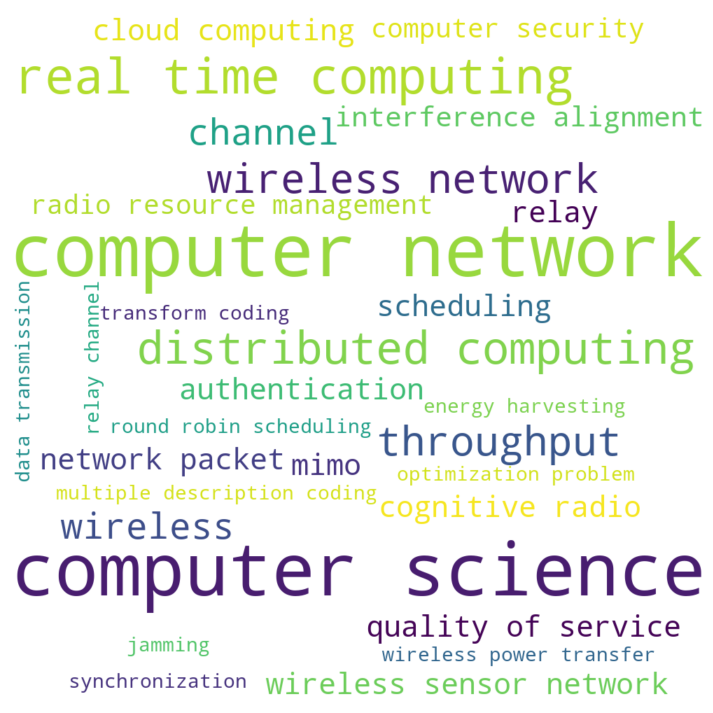

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

d = {}
for a, x in topics.values:
    d[a] = x

wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10)# stopwords = stopwords,
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

In [ ]:
len(words

30

In [ ]:
import plotly.express as px
# Can count number of authors or number of papers from each country
map_data = px.data.gapminder().query("year==2007")[["iso_alpha","country","continent"]]
# df
map_data = colabs[1:].merge(map_data,how="left").dropna()
fig = px.scatter_geo(map_data, locations="iso_alpha",color="continent",
                     hover_name="country",size="count")
fig.show()

In [ ]:
Summary

,author_id,name,country,last_affiliation,papers_count,avg_order,avg_citations,total_citations,h_index,last_paper_id,all_paper_id
0,688402840,victor c m leung,Canada,University of British Columbia,17,3.588235,14.705882,250,5,2243559354,"[2243559354, 2330562129, 2011755788, 197357285..."


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
labels = ["total_citations","papers_count","avg_order","avg_citations","h_index"]
                          
fig = make_subplots(rows=1, cols=5)
i = 1
flag = True
for label in labels: 
  fig_1 = go.Figure(data=[
                go.Bar(name='Average', x=[label], y=[avg_data[label].iloc[0]],
                       marker_color='red',showlegend=flag),
                go.Bar(name='Selected Author', x=[label], y=[Summary[label].iloc[0]],
                       marker_color='blue',showlegend=flag)
                ])
  fig.add_trace(fig_1["data"][0],row=1,col=i)
  fig.add_trace(fig_1["data"][1],row=1,col=i)  
  i=i+1
  flag = False

fig.update_layout(height=600, width=800, title_text="Author's Stats Compared to Average")
fig.show()

In [ ]:
import plotly.express as px
plt_data = avg_data.append(min_data.append(
                          max_data.append(
                          Summary[["total_citations","papers_count","avg_order","avg_citations","h_index"]]
                          )))
plt_data["Label"] = ["Average","Min","Max","Selected Author"]
plt_data["Label_id"] = [1,0,4,2]
fig = px.parallel_coordinates(plt_data,color="Label_id",
                              dimensions=["total_citations","papers_count","avg_order","avg_citations","h_index"],
                              color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                     (0.25, "purple"), (0.50, "purple"),
                                                     (0.50, "blue"),  (0.75, "blue"),
                                                      (0.75, "green"),  (1, "green")])
                            #  color_continuous_scale=px.colors.diverging.Tealrose,
                            #  color_continuous_midpoint=2)
fig.update_layout(coloraxis_colorbar=dict(
    title="Label",
    tickvals=[1,0,4,2],
    ticktext=["Average","Min","Max","Selected Author"],
    lenmode="pixels", len=300,
))
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[1, 5, 2, 2, 3],
    theta=['processing cost','mechanical properties','chemical stability',
           'thermal stability', 'device integration']))
df = Summary[["total_citations","papers_count","avg_order","avg_citations","h_index"]]
fig = px.line_polar(df, r=df.iloc[0], theta=df.columns,line_close=True)
fig.update_traces(fill='toself')
fig.show()


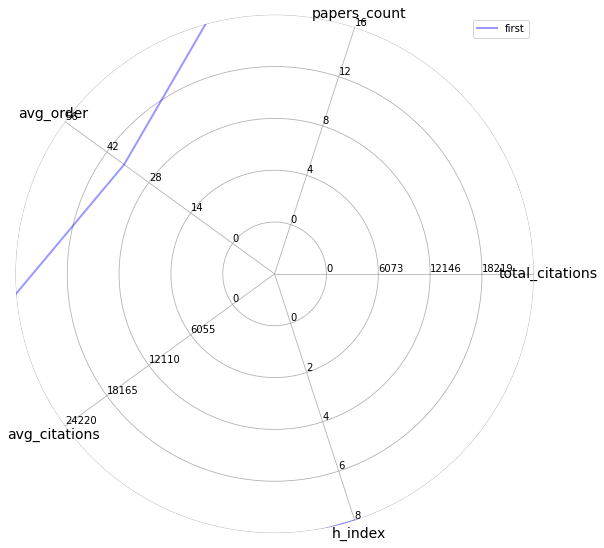

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

fig = plt.figure(figsize=(8, 8))

lab = [
       list(range(0,max_data.iloc[0,0],floor(max_data.iloc[0,0]/4))),
       list(range(0,max_data.iloc[0,1],floor(max_data.iloc[0,1]/4))),
       list(range(0,int(max_data.iloc[0,2]),floor(max_data.iloc[0,2]/4))),
       list(range(0,int(max_data.iloc[0,3]),floor(max_data.iloc[0,3]/4))),
       list(range(0,max_data.iloc[0,4],floor(max_data.iloc[0,4]/4)))
]

radar = Radar(fig, df.columns, lab)
radar.plot(df.iloc[0],  '-', lw=2, color='b', alpha=0.4, label='first')
radar.ax.legend()
plt.show()

In [ ]:
avg_data = data3.select("papers_count","avg_order","avg_citations","total_citations","h_index")\
     .agg(F.avg("total_citations").alias("total_citations"),\
         F.avg("papers_count").alias("papers_count"),\
          F.avg("avg_order").alias("avg_order"),\
          F.avg("avg_citations").alias("avg_citations"),\
          F.avg("h_index").alias("h_index"))\
     .toPandas()

max_data = data3.select("papers_count","avg_order","avg_citations","total_citations","h_index")\
     .agg(F.max("total_citations").alias("total_citations"),\
         F.max("papers_count").alias("papers_count"),\
          F.max("avg_order").alias("avg_order"),\
          F.max("avg_citations").alias("avg_citations"),\
          F.max("h_index").alias("h_index"))\
     .toPandas()

min_data = data3.select("papers_count","avg_order","avg_citations","total_citations","h_index")\
     .agg(F.min("total_citations").alias("total_citations"),\
         F.min("papers_count").alias("papers_count"),\
          F.min("avg_order").alias("avg_order"),\
          F.min("avg_citations").alias("avg_citations"),\
          F.min("h_index").alias("h_index"))\
     .toPandas()

In [ ]:
# Output based on Author Test
Author_Selected = 688402840

# Stats and Facts
Summary = data3.filter(data4["author_id"]==Author_Selected).show()

# Topics
topics = data4.filter(data4["author_id"]==Author_Selected)\
              .select("topics","count")\
              .sort("count",ascending=False).show()

# Colabs
colabs = test.filter(test["author_id"]==Author_Selected).sort("count",ascending=False).show()
# drop first row and join with data2


# Info on Last Paper or top Papers (H-Index?)

+---------+----------------+-------+--------------------+------------+-----------------+------------------+---------------+-------------+--------------------+
|author_id|            name|country|    last_affiliation|papers_count|        avg_order|     avg.citations|total_citations|last_paper_id|        all_paper_id|
+---------+----------------+-------+--------------------+------------+-----------------+------------------+---------------+-------------+--------------------+
|688402840|victor c m leung| Canada|University of Bri...|          17|3.588235294117647|14.705882352941176|            250|   2243559354|[2243559354, 2330...|
+---------+----------------+-------+--------------------+------------+-----------------+------------------+---------------+-------------+--------------------+

+--------------------+-----+
|              topics|count|
+--------------------+-----+
|    computer network|   17|
|    computer science|   17|
| real time computing|    6|
|distributed compu...|    5|
|

In [ ]:
# Your h-index is based on a list of your publications ranked in descending order by the Times Cited count. 
# The value of h is equal to the number of papers (N) in the list that have N or more citations.